#### This script creates world maps of cloud bands detected with global thresholding methods (Yen vs Otsu). It shows different dates in the South Pacific.

Importation of appropriate packages

In [1]:
import os
import string
import sys
from datetime import datetime
import warnings

import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
LAT_FORMAT = LatitudeFormatter(degree_symbol="")


from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.io_utilities import (
    load_ymlfile,
    load_dataset,
    subset_latitudes,
    subset_longitudes,
)
from cloudbandpy.misc import compute_resolution, wrapTo180
from cloudbandpy.time_utilities import create_list_of_dates, add_startend_datetime2config

Load configuration files

In [5]:
# Load configuration file
config_file = os.path.join("../../config/", "config_cbworkflow_southPacific.yml")
config = load_ymlfile(config_file, isconfigfile=True)
# update configuration for this study
config["parameters_file"] = os.path.join("../../parameters", "parameters_southhemisphere.yml")
config["clouddata_path"] = os.path.join("../../data")
# deactivate tracking for efficiency
config["run_inheritance_tracking"] = False

# Create longitudes and latitudes for the specific region
lons_globe = np.arange(0,360,.5)
lats_globe = np.arange(90,-90.5,-.5)
_, lons = subset_longitudes(lons_globe, config["lon_west"], config["lon_east"])
_, lats = subset_latitudes(lats_globe, config["lat_north"], config["lat_south"])
resolution = compute_resolution(lons, lats)
# Load parameters directly from directory
parameters = load_ymlfile(config["parameters_file"])

2024-02-06 14:25:05,646 - io_utilities.load_ymlfile - INFO: Configuration file loaded
2024-02-06 14:25:05,678 - io_utilities.load_ymlfile - INFO: Parameters file loaded


Load data from 2 different years from ERA5 data (cropped on the South Pacific domain and times from year-01-01 to year-05-01) and run detection for the three thresholding methods (default, Yen and Otsu histogram based techniques).

In [7]:
lstdates = ["20210215.00", "20160419.00"]
methods = ["Default", "Yen", "Otsu"]
inc = 0

# Preallocate array for cloud bands, for each
cloud_bands_over_time_thres = np.empty([len(lstdates) * len(methods), len(lats), len(lons)])

for idates in lstdates:
    # Load data from saved variable files
    config_copy = config.copy()
    config_copy["startdate"] = idates
    config_copy["enddate"] = idates
    add_startend_datetime2config(config_copy)
    listofdates = create_list_of_dates(config_copy)
    variable2process, _, _ = load_dataset(config_copy)
    parameters_copy = parameters.copy()
    for ithresh in methods:
        parameters_copy["thresholding_method"] = ithresh
        (_, _, _, _, cloud_bands_over_time, _, _) = detection_workflow(
            var2process=variable2process,
            parameters=parameters_copy,
            latitudes=lats,
            longitudes=lons,
            resolution=resolution,
            listofdates=listofdates,
            config=config,
        )
        cloud_bands_over_time_thres[inc] = cloud_bands_over_time[0]
        inc += 1
    del config_copy

2024-02-06 14:26:04,045 - io_utilities.load_dataset - INFO: Loading dataset from ../../data
2024-02-06 14:26:04,046 - io_utilities.load_dataset - INFO: Loading 2021 --> 2021
2024-02-06 14:26:06,879 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2024-02-06 14:26:06,882 - io_utilities.make_daily_average - INFO: Computation of daily average
2024-02-06 14:26:06,911 - io_utilities.make_daily_average - INFO: Computation of daily average done
2024-02-06 14:26:06,912 - io_utilities.load_dataset - INFO: Dataset loaded
2024-02-06 14:26:06,913 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2024-02-06 14:26:06,925 - cb_detection.detection_workflow - INFO: Cloud band detection done
2024-02-06 14:26:06,926 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2024-02-06 14:26:06,958 - cb_detection.blob_detection - WARNING: Use Yen thresholding method. Threshold:230.6290967024459
2024-02-06 14:26:06,970 - cb_de

#### Create maps showing the three methods

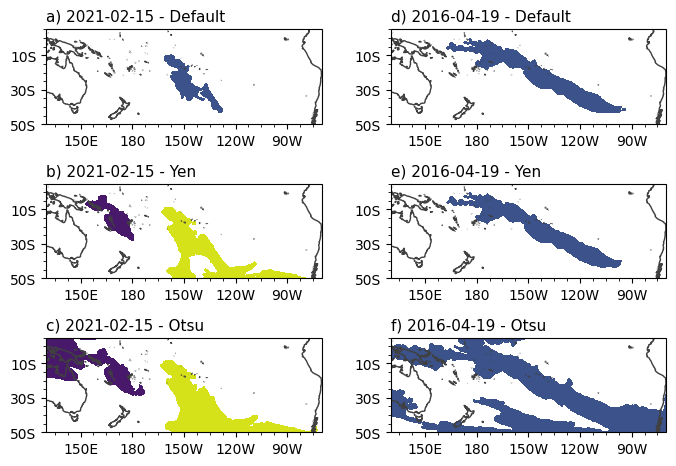

In [8]:
# Initialize variables for plot
# for panel numbering
alphabet = list(string.ascii_lowercase)
# for dates in title
date_format = "%Y%m%d.%S"

lat_north, lat_south = round(lats[0]), round(lats[-1])
lonticks = np.concatenate((np.arange(0, 180, 30), np.arange(-180, 0, 30)))
latticks = np.arange(-90, 110, 20)

fig, ax = plt.subplots(
    nrows=len(methods), ncols=len(lstdates), figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)}
)
inc = 0
for i, idate in enumerate(lstdates):
    datetime_obj = datetime.strptime(idate, date_format)
    datetime_string = datetime_obj.strftime("%Y-%m-%d")
    for j, met in enumerate(methods):
        ax[j,i].contourf(
            lons,
            lats,
            np.ma.masked_where(cloud_bands_over_time_thres[inc] == 0, cloud_bands_over_time_thres[inc]),
            transform=ccrs.PlateCarree(),
        )
        ax[j,i].set_title(f"{alphabet[inc]}) {datetime_string} - {met}", loc="left", fontsize=11)
        ax[j,i].set_yticks(np.arange(-90, 110, 20), crs=ccrs.PlateCarree())
        ax[j,i].set_xticks(lonticks, crs=ccrs.PlateCarree())
        ax[j,i].set_yticks(latticks, crs=ccrs.PlateCarree())
        ax[j,i].xaxis.set_major_formatter(LON_FORMAT)
        ax[j,i].yaxis.set_major_formatter(LAT_FORMAT)
        ax[j,i].minorticks_on()
        ax[j,i].coastlines("50m", color="#404040")
        ax[j,i].set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
        ax[j,i].set_ylim([lat_south, lat_north])
        inc += 1

fig.subplots_adjust(wspace=0.25, hspace=0.001)
plt.show()
fig.savefig("./fig11.png", dpi=300, bbox_inches="tight")